# NER

- 데이터
    - CoNLL - the Conference on Natural Language Learning
    - https://github.com/Franck-Dernoncourt/NeuroNER

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

In [2]:
ner_train_path = tf.keras.utils.get_file("ner_train.txt", "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/refs/heads/master/neuroner/data/conll2003/en/train.txt")
ner_test_path = tf.keras.utils.get_file("ner_test.txt", "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/refs/heads/master/neuroner/data/conll2003/en/test.txt")

### 데이터 전처리

1. (word, ner) 변환
2. 토큰화
3. sequence 처리
4. padding 처리

In [3]:
# (word, ner) tagging
def get_tagged_sentences(path):
    temp = []
    sentences = []

    for line in open(path, 'r', encoding='utf-8'):
        if line.startswith('-DOCSTART') or line[0] == '\n':
            if len(temp) > 0:
                sentences.append(temp)
                temp=[]
            continue

        word, pos, chunk, ner = line.split()
        ner = re.sub('\n', '', ner)
        word = word.lower()
        temp.append((word, ner))

    return sentences

In [4]:
train_tagged_sents = get_tagged_sentences(ner_train_path)
test_tagged_sents = get_tagged_sentences(ner_test_path)

train_tagged_sents[:5]

[[('eu', 'B-ORG'),
  ('rejects', 'O'),
  ('german', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('peter', 'B-PER'), ('blackburn', 'I-PER')],
 [('brussels', 'B-LOC'), ('1996-08-22', 'O')],
 [('the', 'O'),
  ('european', 'B-ORG'),
  ('commission', 'I-ORG'),
  ('said', 'O'),
  ('on', 'O'),
  ('thursday', 'O'),
  ('it', 'O'),
  ('disagreed', 'O'),
  ('with', 'O'),
  ('german', 'B-MISC'),
  ('advice', 'O'),
  ('to', 'O'),
  ('consumers', 'O'),
  ('to', 'O'),
  ('shun', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('until', 'O'),
  ('scientists', 'O'),
  ('determine', 'O'),
  ('whether', 'O'),
  ('mad', 'O'),
  ('cow', 'O'),
  ('disease', 'O'),
  ('can', 'O'),
  ('be', 'O'),
  ('transmitted', 'O'),
  ('to', 'O'),
  ('sheep', 'O'),
  ('.', 'O')],
 [('germany', 'B-LOC'),
  ("'s", 'O'),
  ('representative', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('european', 'B-ORG'),
  ('union', 'I-ORG'),
  ("'s", 'O'),
  ('vete

In [7]:
def get_sents_and_labels(tagged_sentences):
    inputs, labels = [], []
    for sentence in tagged_sentences:
        tokens, ner = zip(*sentence)
        # print(tokens)
        # print(ner)
        inputs.append(list(tokens))
        labels.append(list(ner))

    return inputs, labels

In [8]:
train_inputs, train_labels = get_sents_and_labels(train_tagged_sents)
test_inputs, test_labels = get_sents_and_labels(test_tagged_sents)

print(len(train_inputs), len(train_labels), len(test_inputs), len(test_labels))

14041 14041 3453 3453


min-max: 1 - 113
mean: 14.501887329962253
median: 10.0


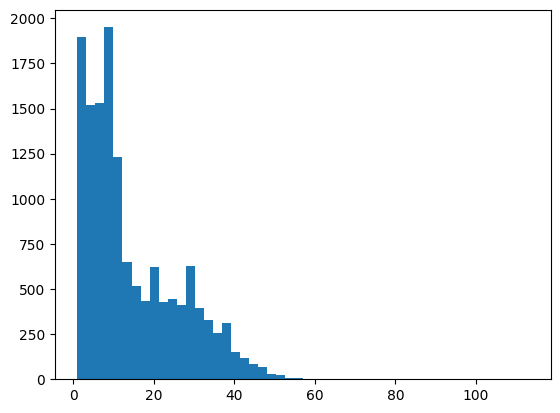

In [12]:
# 데이터 길이 확인
train_len = [len(seq) for seq in train_inputs]

print('min-max:', np.min(train_len), '-', np.max(train_len))
print('mean:', np.mean(train_len))
print('median:', np.median(train_len))


plt.hist(train_len, bins=50)
plt.show()

In [14]:
# sequence - padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_LEN = 50
VOCAB_SIZE = 10000

entity_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_inputs)

X_train = entity_tokenizer.texts_to_sequences(train_inputs)
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='pre', truncating='pre')

In [15]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_labels)

y_train = tag_tokenizer.texts_to_sequences(train_labels)
y_train = pad_sequences(y_train, maxlen=MAX_LEN, padding='pre', truncating='pre')

In [16]:
tag_tokenizer.index_word

{1: 'o',
 2: 'b-loc',
 3: 'b-per',
 4: 'b-org',
 5: 'i-per',
 6: 'i-org',
 7: 'b-misc',
 8: 'i-loc',
 9: 'i-misc'}

In [21]:
X_test = entity_tokenizer.texts_to_sequences(test_inputs)
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

y_test = tag_tokenizer.texts_to_sequences(test_labels)
y_test = pad_sequences(y_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

### 모델 생성 및 학습

In [17]:
from tensorflow.keras import layers, models

EMBED_DIM = 100
LATENT_DIM = 256
TAG_SIZE = len(tag_tokenizer.word_index)

input = layers.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE + 1, EMBED_DIM)(input)
lstm = layers.LSTM(LATENT_DIM, return_sequences = True)
x = layers.Bidirectional(lstm)(x)
output = layers.Dense(TAG_SIZE + 1, activation='softmax')(x)

model = models.Model(input, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 100)        │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 512)        │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 10)         │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,736,366 (6.62 MB)

 Trainable params: 1,736,366 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.8502 - loss: 0.5667 - val_accuracy: 0.9526 - val_loss: 0.1940
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9558 - loss: 0.1546 - val_accuracy: 0.9676 - val_loss: 0.1118
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.9765 - loss: 0.0771 - val_accuracy: 0.9748 - val_loss: 0.0888
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.9863 - loss: 0.0487 - val_accuracy: 0.9781 - val_loss: 0.0769
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.9906 - loss: 0.0354 - val_accuracy: 0.9813 - val_loss: 0.0706
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.9928 - loss: 0.0263 - val_accuracy: 0.9819 - val_loss: 0.0730
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.9937 - loss: 0.0223 - val_accuracy: 0.9811 - val_loss: 0.0736
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.9949 - loss: 0.0183 - val_accu

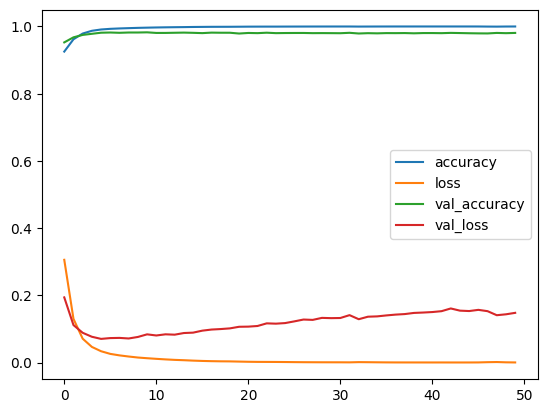

In [20]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs = 50,
    validation_split = 0.2
)

pd.DataFrame(history.history).plot()
plt.show()


### 모델 평가

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test 결과 | Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9803 - loss: 0.1307
Test 결과 | Loss: 0.1325, Accuracy: 0.9805


### NER 예측

In [23]:
sample = ["EU gave German call to take British people wow"]

sample_seq = entity_tokenizer.texts_to_sequences(sample)
sample_padded = pad_sequences(sample_seq, maxlen=MAX_LEN)

In [24]:
pred_proba = model.predict(sample_padded)

pred = np.argmax(pred_proba, axis=-1)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 7,
        1, 1, 1, 7, 1, 1]], dtype=int64)

In [25]:
index2entity = entity_tokenizer.index_word
index2tag = tag_tokenizer.index_word

tokens = [index2entity.get(x, "?") for x in sample_padded[0]]
tags = [index2tag.get(x, "?") for x in pred[0]]

for token, tag in zip(tokens, tags):
    if token != '?':
        print(f'{token}: {tag}')

eu: b-org
gave: o
german: b-misc
call: o
to: o
take: o
british: b-misc
people: o
<OOV>: o
